A basic 3D Immersed Boundary Method code based off of notes from Charles Peskin (https://www.math.nyu.edu/faculty/peskin/ib_lecture_notes/index.html)was implemented in MATLAB by Guanhua Sun and Tristan Goodwill (https://github.com/ModelingSimulation/IB-MATLAB). Here, I (Jackie Sustiel) have translated this code into python, and in this notebook I benchmark and explain the code. 

# Setup

The vanilla IBM code is designed to model a 3D elastic surface embedded in a fluid. The code utilizes two primary classes: FLUID (which contains the fluid solver for incompressible NS) and IB3 (which handles interpolation/extrapolation and force computations for the immersed body). 

To properly model the time evolution of the system, we must calculate both the velocity of the fluid $u^{n+1}$ and the position of the immersed boundary $X^{n+1}$ at each timestep. As in 2D, since the boundary motion is determined by the fluid velocity, and the boundary position determines the force exerted on the fluid, calculating both of these simultaneously is tricky. Consequently, we *iterate* the system by first computing the boundary position at a *half* timestep $X^{n+1/2}$, and use the resulting 'midpoint' force $F^{n+1/2}$ to compute both the updated fluid velocity $u^{n+1}$, and the 'midpoint' fluid velocity $u^{n+1/2}$ used to compute the updated boundary position $X^{n+1}$.

Geometrical boundary representations and force calculations are also more complicated in 3D. We represent boundaries using *triangulated surfaces*, and introduce methods (translated from the 3D MATLAB code) to instantiate a triangulated sphere, which we will use to represent the immersed boundary. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import tri
from trisph import trisph

%matplotlib notebook 

from fluid3 import FLUID    #### Generic fluid solver
from ib3 import IB3         #### 3D Immersed Boundary object
import warnings; warnings.simplefilter('ignore')
from time import time

#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids, ext=None):
    dt = fluid.dt
    fluid.t += dt
    
    ff = 0. ## Force density on fluid
    for solid in solids:
        solid.step_XX(fluid.u)
        ff += solid.ff # Force at midpoint
    
    if ext is not None:   ## External force on fluid.    **NOTE: add this after the solid forces (not before), otherwise numpy gets cranky
        ff += ext
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
        solid.step_X(uu) # full step using midpoint velocity  

# Replicating the MATLAB example

To start, we replicate the example presented in the 3D MATLAB code: a sphere in a plane-wave flow. This serves not only as a useful test case, but also illustrates a more general procedure for modeling a system. First, we initialize the fluid, and specify the fluid parameters and the initial velocity field. Next, we initialize the boundary and specify the boundary parameters, including the surface elasticity $K$. Finally, we iterate the fluid and the immersed solid to model the system in time.

## Fluid

We initialize the fluid, specifying density $\rho$ and viscosity $\eta$; the domain length $L$ and resolution $N$; and the timestep $dt$. This particular fluid solver uses fast fourier transforms (fft) to solve the incompressible NS on periodic boundary conditions, but any fluid solver can be used. A popular alternative is the LB-IBM, in which the lattice boltzmann method is used to solve the fluid instead. 

In this example, we set the velocity at at $t=0$ to be a plane wave: $u(x, y, z) = \sin\frac{2\pi y}{L}\hat{z} +  \sin\frac{2\pi z}{L}\hat{x}$. 

Arrays can be constructed via for loops, via projection, or by indexing via meshgrid. The results are the same:
True
True
True



<IPython.core.display.Javascript object>


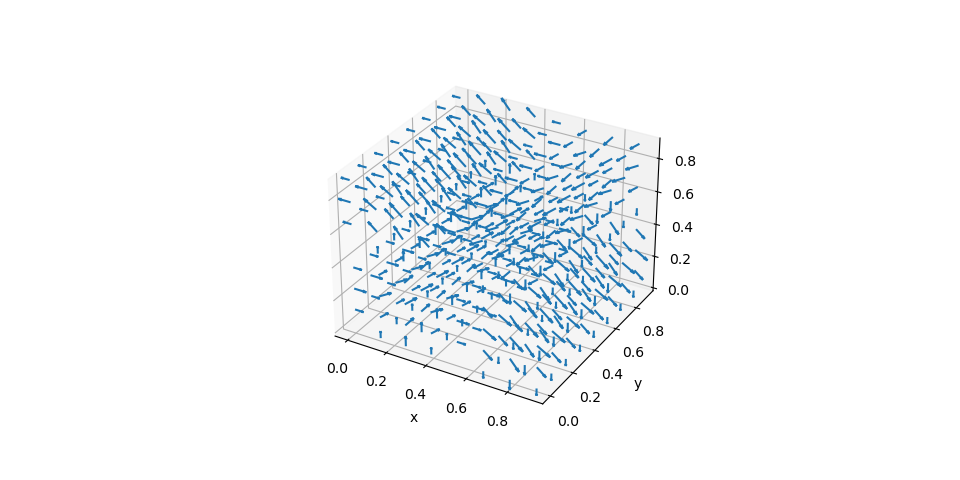

Text(0.5, 0, 'y')

In [27]:
#### Initialize the fluid
fluid = FLUID(L=1., N=32)   #### We use the other default parameters rho=1., eta=.01, dt=.01

#### Specify the initial fluid velocity
## Following MATLAB code
au1 = np.array([0,0,1])
ku1 = np.array([0,1,0])
au2 = np.array([1,0,0])
ku2 = np.array([0,0,1])

for j1 in range(fluid.N):  
    for j2 in range(fluid.N):    
        for j3 in range(fluid.N):
            xu = fluid.h*np.array([j1, j2, j3])
            fluid.u[:, j1, j2, j3] = au1*np.sin(2*np.pi*xu[1]/fluid.L) + au2*np.sin(2*np.pi*xu[2]/fluid.L)
            
# ## Using projection
u1 = 0*fluid.u
theta = np.linspace(0, 2*np.pi, fluid.N+1)
theta = theta[:-1]
u1[2] = np.sin(theta)[None, :, None]
u1[0] = np.sin(theta)[None, None, :]

## Using meshgrid
u2 = 0*fluid.u
thX, thY, thZ = np.meshgrid(theta, theta, theta, indexing='ij')
u2[2] = np.sin(thY)
u2[0] = np.sin(thZ)

print('Arrays can be constructed via for loops, via projection, or by indexing via meshgrid. The results are the same:')
print((u1==fluid.u).all())
print((u2==fluid.u).all())
print((u1==u2).all())

print()


#### Plot the fluid velocity
def quiver_vel(fluid, ax, r=1):
    res = np.arange(fluid.N)[::r]
    RES = np.meshgrid(res, res, res)
    nx = np.linspace(0, fluid.L, fluid.N)
    NX, NY, NZ = np.meshgrid(nx, nx, nx)

    return ax.quiver(NX[RES], NY[RES], NZ[RES], fluid.u[0][RES], fluid.u[1][RES], fluid.u[2][RES], length=2*fluid.h)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

quiver_vel(fluid, ax, 4)

plt.xlabel('x')
plt.ylabel('y')


In [4]:
#### Instantiate the immersed boundary
x, v = trisph(rad=1./3, ctr=[0.5, 0.5, 0.5], numr=3)
print('Sphere has {} vertices and {} triangles'.format(np.shape(x)[0], np.shape(v)[0]))

X = np.vstack([x[:,0], x[:,1], x[:,2]])
solid = IB3(X, fluid.N, fluid.h, fluid.dt, K=1.)
solid.v = v
solids = [solid]

#### Some things for plotting later. Find area of triangles, and store boundary position
GRAD_ARR = lambda solid: np.vstack([solid.grad(*[solid.X[:, vi] for vi in v]) for v in solid.v])
areas_0 = np.linalg.norm(GRAD_ARR(solid), axis=1)
Xt = []

Sphere has 645 vertices and 1280 triangles


In [5]:
## Run the simulation
for i in range(150):
    iterate(fluid, solids)
    if i%10==0:
        print(i)
        Xt.append(solids[0].X.copy())   #### Save boundary position at this time


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


Now, let's plot the boundary position over time. The first scatter plot superimposes the boundary positions at various times, with the lightest points corresponding to $t=0$ and the darker points corresponding to later times approaching $t=t_f$. Then, the following trisurface sequence of trisurf plots show the surface as it evolves through time.

<IPython.core.display.Javascript object>


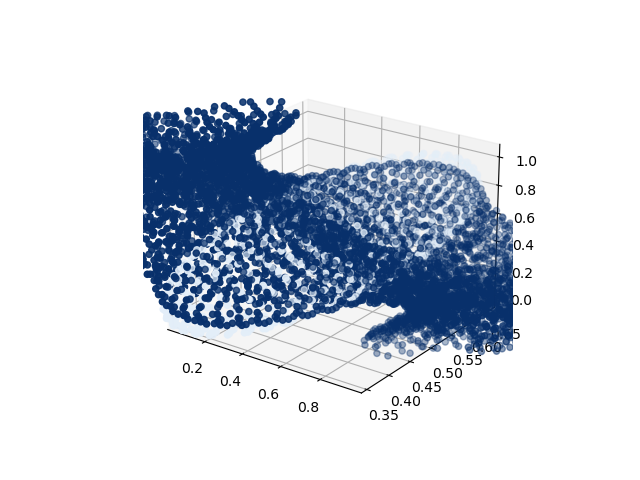

<IPython.core.display.Javascript object>


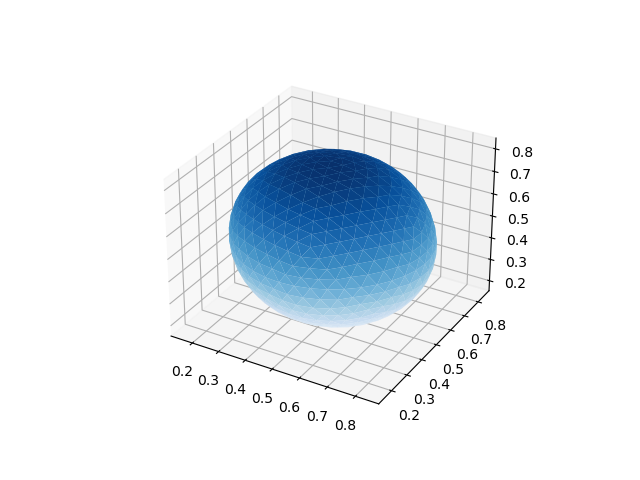

<IPython.core.display.Javascript object>


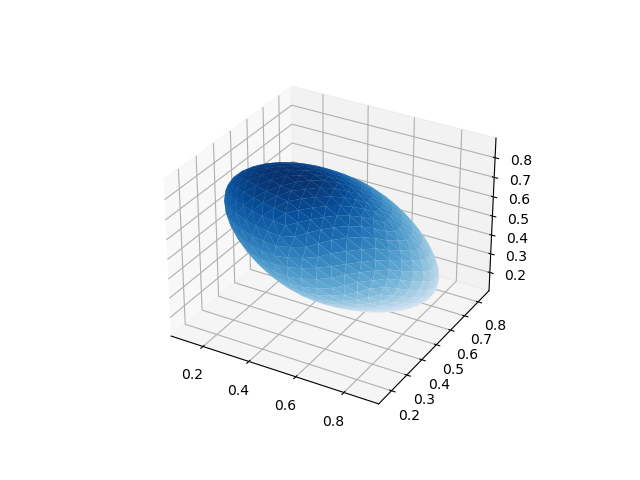

<IPython.core.display.Javascript object>


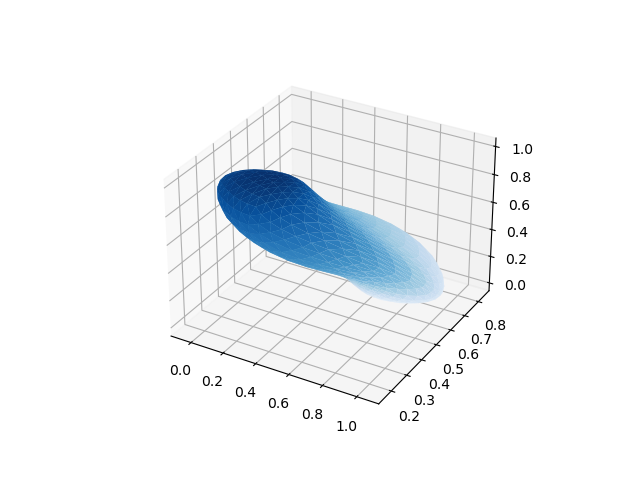

<IPython.core.display.Javascript object>


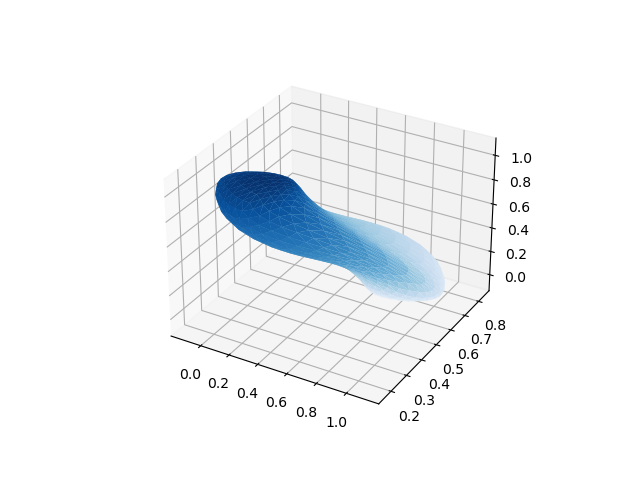

<IPython.core.display.Javascript object>


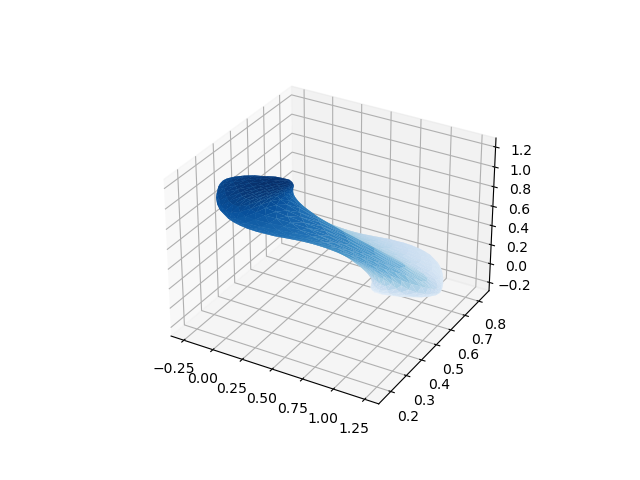

<IPython.core.display.Javascript object>


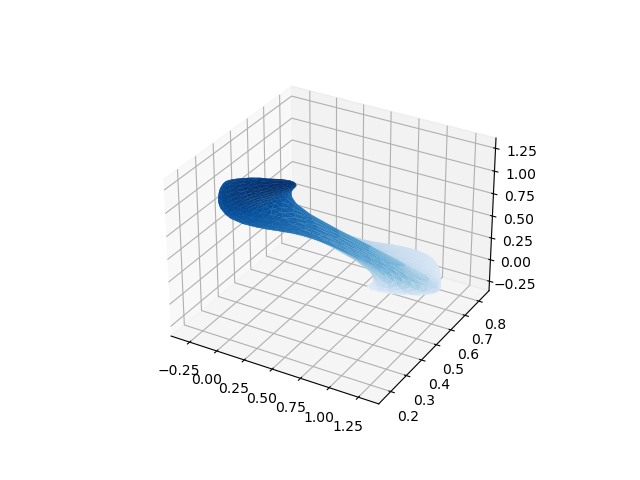

<IPython.core.display.Javascript object>


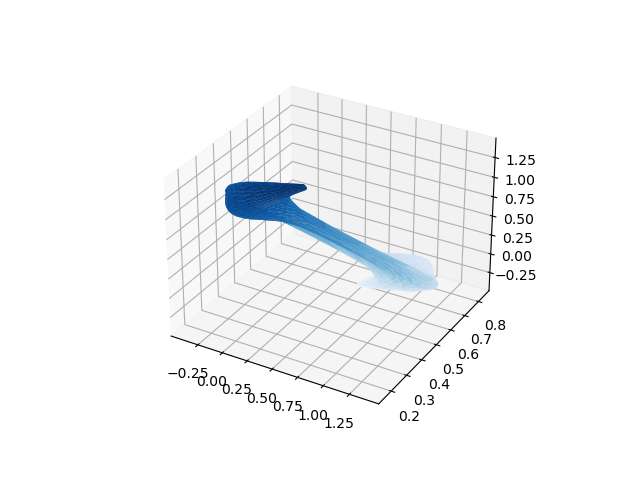

<IPython.core.display.Javascript object>


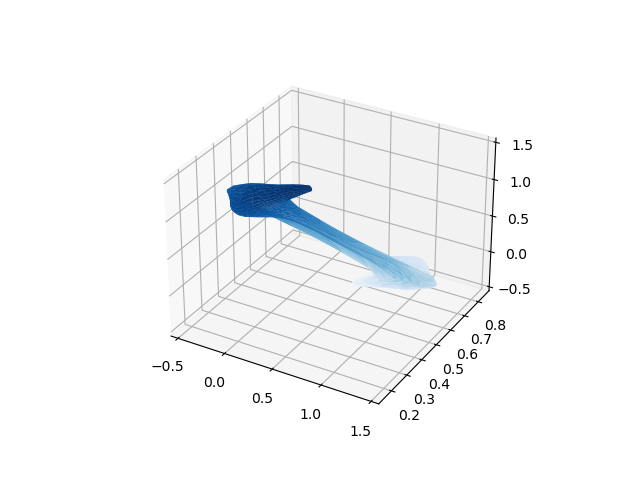

<IPython.core.display.Javascript object>


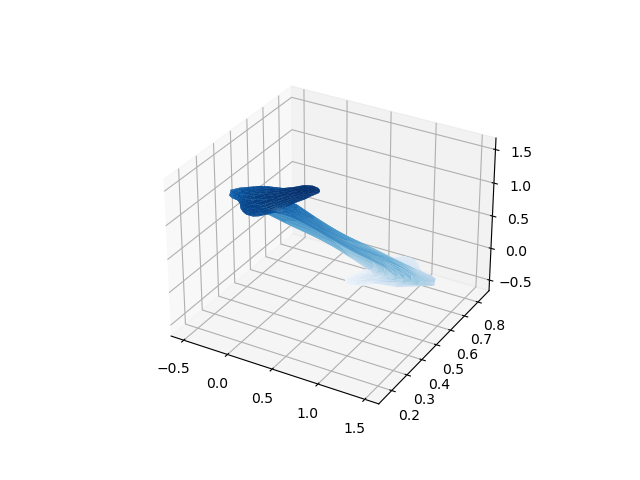

<IPython.core.display.Javascript object>


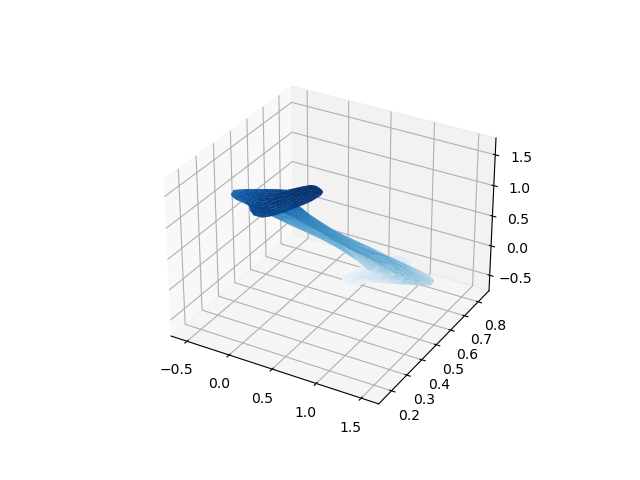

In [5]:
#### Plot the geometry of the surface over time

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap('Blues')


for i in [int(n) for n in np.linspace(0, len(Xt)-1, 10)]:
    ax.scatter(Xt[i][0], Xt[i][1], Xt[i][2], color=cmap(0.1+i*.9))
    fig = plt.figure()
    ax2 = fig.add_subplot(projection='3d')
#     ax2.plot_trisurf(Xt[i][0], Xt[i][1], Xt[i][2], triangles=solid.v, linewidth=1, cmap=None, shade=False, edgecolor=cmap(0.1+i*.9))
    ax2.plot_trisurf(Xt[i][0], Xt[i][1], Xt[i][2], triangles=solid.v, cmap=cmap)


# for i in [0]:
#     ax.plot_trisurf(Xt[i][0], Xt[i][1], Xt[i][2], triangles=solid2.v, linewidth=1, cmap=None, shade=False, edgecolor=cmap(0.1+i*.9))


# Re-Meshing

In the example illustrated above, the boundary forces are determined by surface tension - i.e. the forces minimize the energy functional corresponding to surface area. However, these deformations do not restrict the size of individual triangles: some triangles may become very large, and others may become very small. This is illustrated by the histograms presented below of triangle surface area at $t=0$ and $t=t_f$. 

Triangles which are too small/large may introduce instabilities, so occasional remeshing is sometimes necessary throughout the simulation. 

<IPython.core.display.Javascript object>


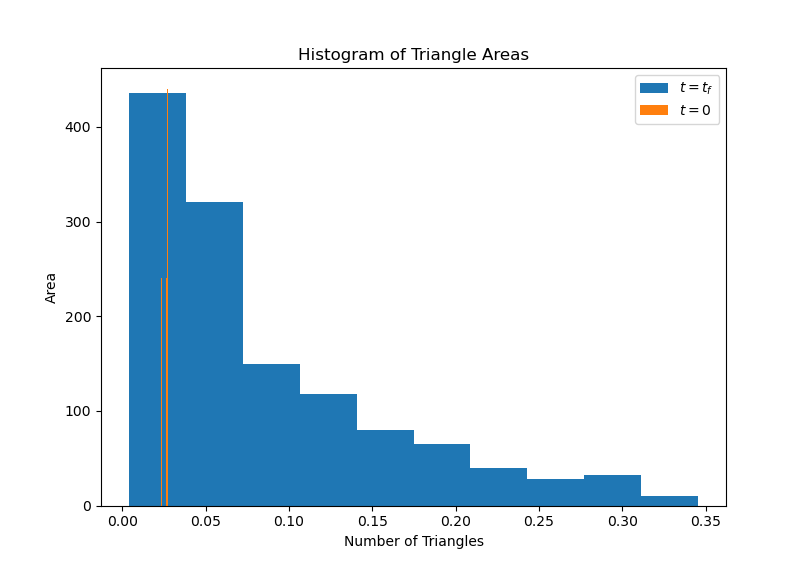

Text(0.5, 1.0, 'Histogram of Triangle Areas')

In [7]:
fig = plt.figure()
plt.hist(np.linalg.norm(GRAD_ARR(solid), axis=1), label='$t=t_f$')
plt.hist(areas_0, label='$t=0$')
plt.legend()
plt.ylabel('Area')
plt.xlabel('Number of Triangles')
plt.title('Histogram of Triangle Areas')

In [43]:
# T = np.arange(16)
# print(T)
# print(T[::4, ::4])

# TT = np.meshgrid(T, T)

# print(TT)
# print(TT[0][::4])
# def DECIMATE(ARRAYS, rx, ry, rz): return [ARRAY[::rx, ::ry, ::rz] for array in ARRAYS]
# def DECIMATE(ARRAYS, rx, ry, rz): return [ARRAY[::rx, ::ry, ::rz] for array in ARRAYS]
# # def DECIMATE(ARRAYS, FACTORS): return [array[*[::fact for fact in FACTORS]] for array in ARRAYS]
# def DECIMATE(ARRAYS, FACTORS): 
#     s_index = ','.join(['::{}'.format(fact) for fact in FACTORS])
#     print(s_index)
    
#     return [array[eval(s_index)] for array in ARRAYS]


# TTm = DECIMATE(TT, [4, 4])

# Visualizing the Discrete Delta Function

What is the discrete dirac delta function, and how can we visualize it in 3D? Essentially, the delta function can be used to interpolate a field at a Lagrangian (off-grid) point by taking a weighted mean of nearby Eulerian (on-grid) points, or by doing the reverse to spread Lagrangian forces to the Eulerian grid. 

To try and help visualize the delta function, I've plotted the boundary points of a sphere in 3D space below, and plotted contours of the delta function along select 'slices' in 2D planes. 

Note that the delta function, which here is plotted in $eulerian$ space, is largest near boundary points - Lagrangian quantities are calculated using the field at the 4x4x4 Eulerian points, with the nearer points being weighted more heavily.

<IPython.core.display.Javascript object>


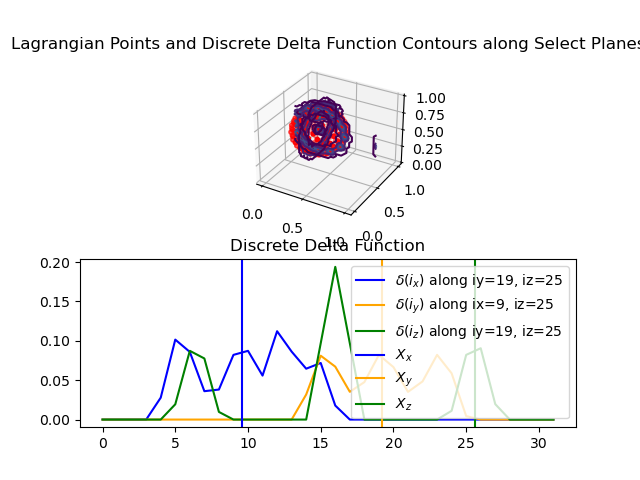

Lagrangian Points:
[[0.3        0.38291796 0.08291796 0.08291796 0.38291796 0.56832816
  0.51708204 0.21708204 0.03167184 0.21708204 0.51708204 0.3
  0.3        0.22114033 0.17240238 0.34873795 0.04480476 0.17240238
  0.22114033 0.34873795 0.50645729 0.45771933 0.50645729 0.12366442
  0.3        0.01468305 0.01468305 0.3        0.12366442 0.58531695
  0.47633558 0.47633558 0.58531695 0.37885967 0.09354271 0.09354271
  0.37885967 0.55519524 0.25126205 0.42759762 0.14228067 0.25126205
  0.42759762 0.3        0.25854102 0.28416408 0.19145898 0.16583592
  0.09875388 0.09875388 0.25854102 0.19145898 0.28416408 0.40854102
  0.43416408 0.49145898 0.40854102 0.49145898 0.43416408 0.25854102
  0.2072949  0.16583592 0.01583592 0.         0.01583592 0.16583592
  0.2072949  0.25854102 0.50124612 0.5427051  0.55854102 0.55854102
  0.5427051  0.50124612 0.34145898 0.3927051  0.43416408 0.04145898
  0.0572949  0.09875388 0.09875388 0.0572949  0.04145898 0.43416408
  0.3927051  0.34145898 0.58416408 0

<IPython.core.display.Javascript object>


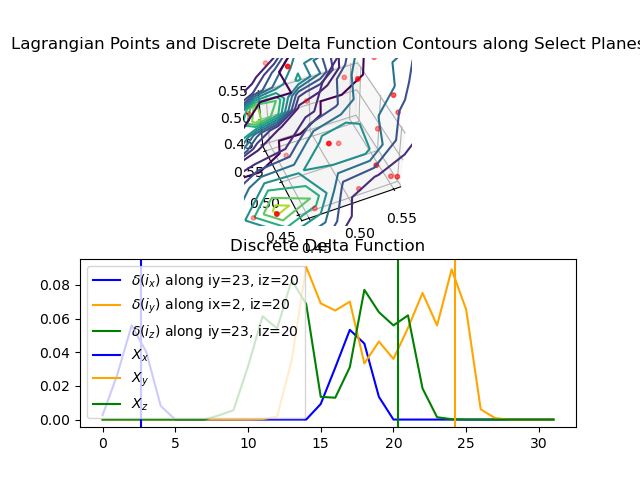

Lagrangian Points:
[[0.3        0.38291796 0.08291796 0.08291796 0.38291796 0.56832816
  0.51708204 0.21708204 0.03167184 0.21708204 0.51708204 0.3
  0.3        0.22114033 0.17240238 0.34873795 0.04480476 0.17240238
  0.22114033 0.34873795 0.50645729 0.45771933 0.50645729 0.12366442
  0.3        0.01468305 0.01468305 0.3        0.12366442 0.58531695
  0.47633558 0.47633558 0.58531695 0.37885967 0.09354271 0.09354271
  0.37885967 0.55519524 0.25126205 0.42759762 0.14228067 0.25126205
  0.42759762 0.3        0.25854102 0.28416408 0.19145898 0.16583592
  0.09875388 0.09875388 0.25854102 0.19145898 0.28416408 0.40854102
  0.43416408 0.49145898 0.40854102 0.49145898 0.43416408 0.25854102
  0.2072949  0.16583592 0.01583592 0.         0.01583592 0.16583592
  0.2072949  0.25854102 0.50124612 0.5427051  0.55854102 0.55854102
  0.5427051  0.50124612 0.34145898 0.3927051  0.43416408 0.04145898
  0.0572949  0.09875388 0.09875388 0.0572949  0.04145898 0.43416408
  0.3927051  0.34145898 0.58416408 0

In [10]:
'''  Display how the 3D Delta Function looks around some select points'''
## Reference: https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib


x, v = trisph(rad=.3, ctr=[0.3, 0.6, 0.5], numr=2)

x = np.vstack([x[:,0], x[:,1], x[:,2]])
solid1 = IB3(x, fluid.N, fluid.h, fluid.dt, K=2.5)
solid1.v = v

i_lpoint = 0
ix = 9
iy = 19
iz = 25

def show_phi_for_point(i_lpoint, ix, iy, iz):
    fig = plt.figure()
    W = solid1.show_phi()
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    ax.set_zlim((0.,fluid.L))
    nx = np.linspace(0, fluid.L, fluid.N)
    X, Y = np.meshgrid(nx, nx)

    lpoint = solid1.X[:,i_lpoint]


    print('Lagrangian Points:')
    print(solid1.X)
    print('Eulerian Coordinates:')
    print(nx)
    print()
    print('A lagrangian point is {}'.format(lpoint))
    print('A nearby eulerian point is at ({}, {}, {}) or index {}, {}, {}'.format(nx[ix], nx[iy], nx[iz], ix, iy, iz))


    # ax.contour(X, Y, W[:,:,18].transpose(), 10, zdir='z',  offset=18*fluid.L/32)
    ax.contour(W[ix,:,:], Y, X, 10, zdir='x',  offset=ix*fluid.L/fluid.N, marker='.')
    ax.contour(Y, W[:,iy,:], X, 10, zdir='y',  offset=iy*fluid.L/fluid.N, marker='.')
    ax.contour(Y, X, W[:,:,iz], 10, zdir='z',  offset=iz*fluid.L/fluid.N, marker='.')

    ax.scatter(solid1.X[0], solid1.X[1], solid1.X[2], s=10., color='red')
    ax.scatter([solid1.X[0][i_lpoint]], [solid1.X[1][i_lpoint]], [solid1.X[2][i_lpoint]], s=20., color='magenta')
    plt.title('Lagrangian Points and Discrete Delta Function Contours along Select Planes')


    ax = fig.add_subplot(2, 1, 2)
    plt.plot(W[:, iy, iz], color='blue', label='$\delta(i_x)$ along iy={}, iz={}'.format(iy, iz))
    plt.plot(W[ix, :, iz], color='orange', label='$\delta(i_y)$ along ix={}, iz={}'.format(ix, iz))
    plt.plot(W[ix, iy, :], color='green', label='$\delta(i_z)$ along iy={}, iz={}'.format(iy, iz))
    plt.axvline(x=lpoint[0]*32, color='blue', label='$X_x$')
    plt.axvline(x=lpoint[1]*32, color='orange', label='$X_y$')
    plt.axvline(x=lpoint[2]*32, color='green', label='$X_z$')
    plt.legend()
    plt.title('Discrete Delta Function')

show_phi_for_point(i_lpoint, ix, iy, iz)

show_phi_for_point(2, 2, 23, 20)


# Sphere in a Stationary Fluid

To illustrate the effects of surface tension, let's study a few spheres with $u(t=0) = 0$



In [6]:
#### Set up 5 identical systems with one sphere in a fluid, but each with different elasticity K
K = [.1, .5, 1., 2.5, 5.]

fluids = [FLUID(L=2., N=32) for k in K]
x, v = trisph(rad=.3, ctr=[0.4, 0.4, 0.4], numr=2)
x = np.vstack([x[:,0], x[:,1], x[:,2]])
isolids = [ IB3(x.copy(), fluid.N, fluid.h, fluid.dt, K=k)  for k in K]
for solid in isolids: solid.v = v

Xt = [[] for k in K]

In [7]:
#### Run the simulations together
for j in range(len(K)):
    for i in range(500):
        iterate(fluids[j], [isolids[j]])
        if i%10==0:
            print('Simulation {} | i={}'.format(j, i))
            Xt[j].append(isolids[j].X.copy())   #### Save boundary position at this time


Simulation 0 | i=0
Simulation 0 | i=10
Simulation 0 | i=20
Simulation 0 | i=30
Simulation 0 | i=40
Simulation 0 | i=50
Simulation 0 | i=60
Simulation 0 | i=70
Simulation 0 | i=80
Simulation 0 | i=90
Simulation 0 | i=100
Simulation 0 | i=110
Simulation 0 | i=120
Simulation 0 | i=130
Simulation 0 | i=140
Simulation 0 | i=150
Simulation 0 | i=160
Simulation 0 | i=170
Simulation 0 | i=180
Simulation 0 | i=190
Simulation 0 | i=200
Simulation 0 | i=210
Simulation 0 | i=220
Simulation 0 | i=230
Simulation 0 | i=240
Simulation 0 | i=250
Simulation 0 | i=260
Simulation 0 | i=270
Simulation 0 | i=280
Simulation 0 | i=290
Simulation 0 | i=300
Simulation 0 | i=310
Simulation 0 | i=320
Simulation 0 | i=330
Simulation 0 | i=340
Simulation 0 | i=350
Simulation 0 | i=360
Simulation 0 | i=370
Simulation 0 | i=380
Simulation 0 | i=390
Simulation 0 | i=400
Simulation 0 | i=410
Simulation 0 | i=420
Simulation 0 | i=430
Simulation 0 | i=440
Simulation 0 | i=450
Simulation 0 | i=460
Simulation 0 | i=470
Sim

In [18]:
fig = plt.figure()
ims = [ [] for i in Xt[0]]
for i in range(5):
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    ax.set_title('K={}'.format(K[i]))
    for j, im in enumerate(ims):
        im.append(ax.plot_trisurf(Xt[i][j][0], Xt[i][j][1], Xt[i][j][2], triangles=v, cmap=plt.cm.Spectral))
    

<IPython.core.display.Javascript object>

In [20]:
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=100)


1.7185231996879649


<IPython.core.display.Javascript object>


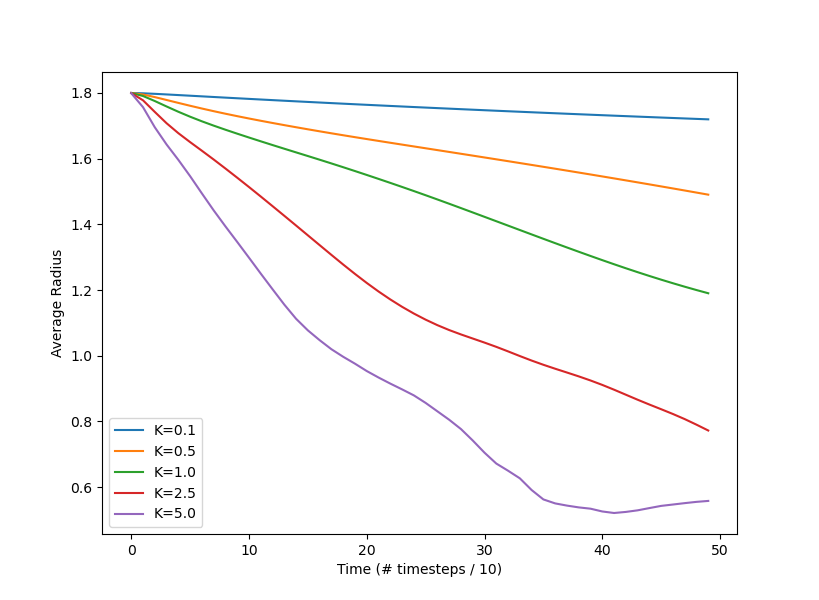

Text(0.5, 0, 'Time (# timesteps / 10)')

In [25]:
def RADIUS(X):
    X0 = np.mean(X, axis=0)
    return np.mean(np.linalg.norm(X-X0, axis=1))

myx = isolids[0].X.copy()

print(RADIUS(myx))
fig = plt.figure()
for i, k in enumerate(K):
    plt.plot([RADIUS(x) for x in Xt[i]], label='K={}'.format(k))
plt.legend()
plt.ylabel('Average Radius')
plt.xlabel('Time (# timesteps / 10)')

# Several Spheres in an (initially) Couette Flow

<IPython.core.display.Javascript object>


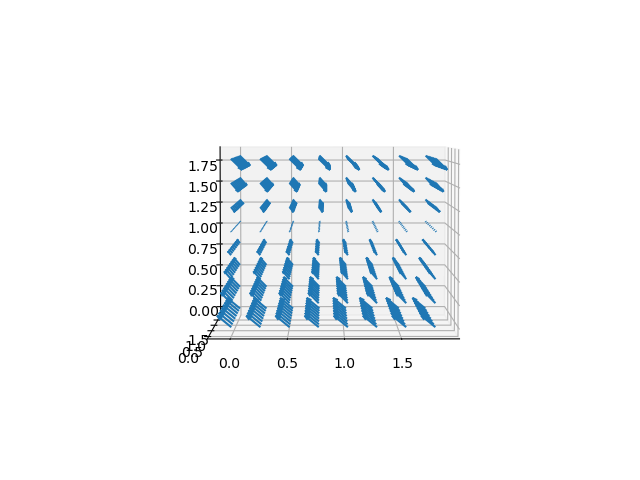

In [35]:
fluid = FLUID(L=2, N=32)
fluid.u[0] = np.linspace(-1, 1, fluid.N)[None, None, :]
fluid.u[2] = np.cos(np.linspace(0, np.pi, fluid.N)[None, None, :])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
quiver_vel(fluid, ax, r=4)


In [63]:
solids = []

x, v = trisph(rad=.3, ctr=[1., 1., 1.], numr=2)
x = np.vstack([x[:,0], x[:,1], x[:,2]])
solid = IB3(x, fluid.N, fluid.h, fluid.dt, K=1.)
solid.v = v
solids.append(solid)
    
x, v = trisph(rad=.15, ctr=[.4, 1., 1.2], numr=2)
x = np.vstack([x[:,0], x[:,1], x[:,2]])
solid = IB3(x, fluid.N, fluid.h, fluid.dt, K=2.)
solid.v = v
solids.append(solid)

x, v = trisph(rad=.15, ctr=[1.5, .9,  .8], numr=2)
x = np.vstack([x[:,0], x[:,1], x[:,2]])
solid = IB3(x, fluid.N, fluid.h, fluid.dt, K=2.)
solid.v = v
solids.append(solid)

Xt = [[] for solid in solids]

In [67]:
#### Run the simulation
for i in range(500):
    iterate(fluid, solids)
    if i%10==0:
        print(i)
        for j, solid in enumerate(solids):
            Xt[j].append(solid.X.copy())   #### Save boundary position at this time


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [68]:
#### Animation
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])
ax.set_zlim((0.,fluid.L))
ims = []
for i in range(len(Xt[0])):
    ims.append([ax.plot_trisurf(Xt[j][i][0], Xt[j][i][1], Xt[j][i][2], triangles=v, cmap=plt.cm.Spectral) for j in range(len(Xt))])


<IPython.core.display.Javascript object>

In [69]:
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=100)


<IPython.core.display.Javascript object>


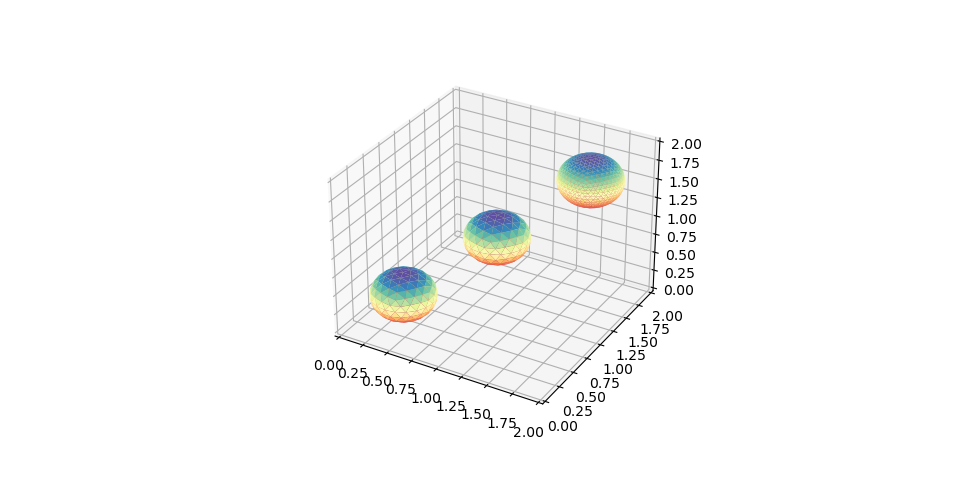

<IPython.core.display.Javascript object>


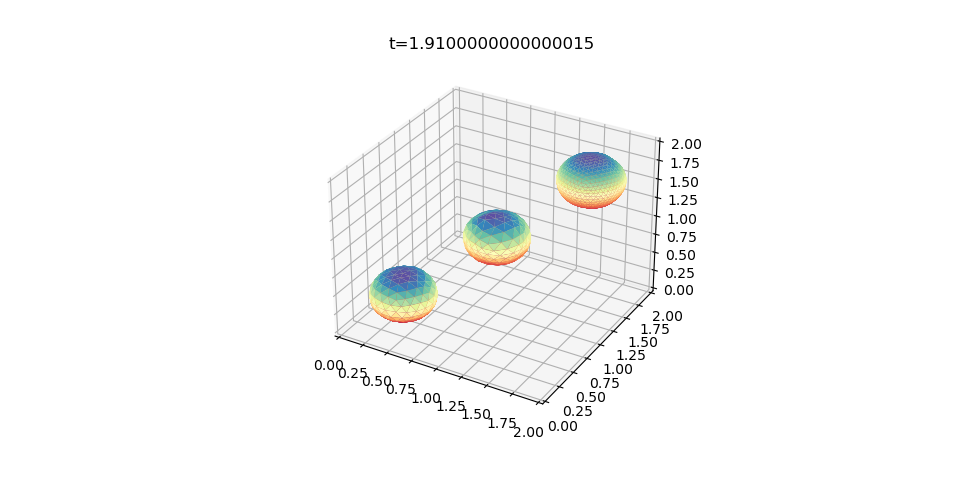

In [15]:
#### Animation
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])
ax.set_zlim((0.,fluid.L))
for solid in solids:
    ax.plot_trisurf(solid.X[0], solid.X[1], solid.X[2], triangles=solid.v, cmap=plt.cm.Spectral)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])
ax.set_zlim((0.,fluid.L))

cmap = plt.get_cmap('tab10')
ims = []

In [17]:
for i in range(100):
    iterate(fluid, solids)
    if i%10==0:
        print(i)
        im = []
        for i, solid in enumerate(solids):
            XXX, YYY, ZZZ = np.meshgrid(solid.X[0], solid.X[1], solid.X[2])
            im.append(ax.plot_trisurf(solid.X[0], solid.X[1], solid.X[2], triangles=solid.v, cmap=plt.cm.Spectral))
#             F = solid.Forcesurf(solid.X, solid.v)
#             im.append(ax.quiver(solid.X[0], solid.X[1], solid.X[2], F[0], F[1], F[2]))
#             im.append(ax.quiver(XXX, YYY, ZZZ, F[0], F[1], F[2]))
#             im.append(plt.scatter(solid.X[0], solid.X[1], color=cmap(2*i)))
#             im.append(plt.scatter([solid.X[0][0]], [solid.X[1][0]], color=cmap(2*i+1)))
#             im.append(plt.scatter(solid.XX[0], solid.XX[1], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        

0
10
20
30
40
50
60
70
80
90


In [13]:
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)

# An Explicit (numerical) Comparison to the MATLAB Code

todo: show test case

# *DEPRACATED*
# Benchmarking the Fluid Solver

In [2]:


########  Simulate pressure-driven flow in no-slip channel    #############

#### Initialization of Fluid+Boundary Conditions
fluid = FLUID(L=2.)

def channel(u):
    u[0][:,:,0] = 0.
    u[0][:,:,-1] = 0.
    u[0][:,0,:] = 0.
    u[0][:,-1,:] = 0.
    
    u[1][:,:,0] = 0.
    u[1][:,:,-1] = 0.
    u[1][:,0,:] = 0.
    u[1][:,-1,:] = 0.
    
    u[2][:,:,0] = 0.
    u[2][:,:,-1] = 0.
    u[2][:,0,:] = 0.
    u[2][:,-1,:] = 0.
    

fluid.boundary = channel    ## No-slip channel

inlet_pressure = 0*fluid.u
inlet_pressure[0][0, :, :] = 1.    ## External force density is pressure-driven flow at inlet


# fig, ax = plt.subplots()
# fig.figsize=(12, 8)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ims = []

# Velocity Profile
plt.title('Velocity Profile at x=N/2')
plt.xlabel('y')
plt.ylabel('vx')


# cmap = plt.get_cmap('tab10')
# y = np.linspace(0, fluid.L, fluid.N)
# u_theo = -1.*y*(y-fluid.L)

# profile_theo = ax.plot(u_theo, color=cmap(1))


#### Vorticity Map
# plt.xlim([0, fluid.L])
# plt.ylim([0, fluid.L])


nx = np.linspace(0, fluid.L, fluid.N)
# fluid.u[2] = np.sin(nx).reshape([1,fluid.N,1]) 
# fluid.u[2] = 1.

res = 8*np.arange(int(fluid.N/8))
RES = np.meshgrid(res, res, res)
NX, NY, NZ = np.meshgrid(nx, (nx+1)%8, (nx+3)%8)
# ax.quiver(NX[RES], NY[RES], NZ[RES], fluid.u[0][RES], fluid.u[1][RES], fluid.u[2][RES])
for i in range(400):
    fluid.t += fluid.dt
    uu = fluid.step_u(inlet_pressure)
    if i%20==0:
        print(i)
        
#         ims.append([ax.quiver(nx, nx, nx, fluid.u[0], fluid.u[1], fluid.u[2])])
        ims.append([ax.quiver(NX[RES], NY[RES], NZ[RES], fluid.u[0][RES], fluid.u[1][RES], fluid.u[2][RES])])
        #Velocity Profile
#         ims.append(ax.plot(fluid.u[0][int(fluid.N/2), int(fluid.N/2)], color=cmap(0)))  ## ax.plot returns a list of 2DLines (e.g. list of artists)
#         ims[-1].extend(profile_theo)

        # Vorticity Map
#         im = [fluid.show_vorticity()]     #### show_vorticity returns output from plt.imshow(), which is an artist
# #         im = []
# #         im.append(fluid.show_streamlines(ax))
#         im.append(plt.title('t={}'.format(1*fluid.t)))
#         ims.append(im)

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
plt.show()



u_pois = fluid.u

<IPython.core.display.Javascript object>

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
